In [1]:
#import necessary libraries
import pandas as pd
import re
import torch
import collections
import numpy as np
import json
import time
from tqdm.notebook import tqdm
import torch.nn as nn
import pathlib

#output all items, not just last one
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

#set device
if torch.cuda.is_available():
    device= "cuda"
else:
    device = "cpu"  
device

'cuda'

In [2]:
#define Articles dataset class for easy sampling, iteration, and weight creating
class Articles(torch.utils.data.Dataset):
    def __init__(self, json_file):
        super().__init__()
        with open(json_file, "r") as data_file:
            self.examples = json.loads(data_file.read())
        self.tokenize()
    
    def __getitem__(self, idx):
        return self.examples[idx]
    
    def __len__(self):
        return len(self.examples)
    
    def tokenize(self):
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = re.findall('[\w]+', self.examples[idx]['text'].lower())
            self.examples[idx]['text'] = list(set(self.examples[idx]['text']))
            self.examples[idx]['title'] = re.findall('[\w]+', self.examples[idx]['title'].lower())
    
    def create_positive_sampler(self):
        prob = np.zeros(len(self))
        for idx, example in enumerate(self.examples):
            if example['publication'] == 0 or example['publication'] == 1 or example['publication'] == 2:
                prob[idx] = 1
        return torch.utils.data.WeightedRandomSampler(weights=prob, num_samples=len(self), replacement=True)
    
    def create_negative_sampler(self):
        prob = np.zeros(len(self))
        for idx, example in enumerate(self.examples):
            if example['publication'] != 0 and example['publication'] != 1 and example['publication'] != 2:
                prob[idx] = 1
        return torch.utils.data.WeightedRandomSampler(weights=prob, num_samples=len(self), replacement=True)
    
    def create_dictionaries(self):
        counter = collections.Counter()
        url_counter = collections.Counter()
        publication_counter = collections.Counter()
        urls = []
        publications = []

        for example in self.examples:
            counter.update(example['text'])
            counter.update(example['title'])
            urls.append(example['url'])
            publications.append(example['publication'])
            
        url_counter.update(urls)
        publkication_counter.update(publications)
        word_to_id = {word: id for id, word in enumerate(counter.keys())}
        article_to_id = {link: id for id, link in enumerate(url_counter.keys())}
        publication_to_id = {publication: id for id, publication in enumerate(publication_counter.keys())}
        return word_to_id, article_to_id, publication_to_id
    
    def map_items(self, word_to_id, url_to_id, publication_to_id):
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = [word_to_id.get(word, len(word_to_id)) for word in example['text']]
            self.examples[idx]['text'] = [word for word in example['text'] if word != len(word_to_id)]
            self.examples[idx]['title'] = [word_to_id.get(word, len(word_to_id)) for word in example['title']]
            self.examples[idx]['title'] = [word for word in example['title'] if word != len(word_to_id)]
            self.examples[idx]['url'] = url_to_id.get(example['url'], len(url_to_id))
            self.examples[idx]['publication'] = publication_to_id.get(example['publication'], len(publication_to_id))

In [3]:
#function to create dictionaries for words and urls for all datasets at once
def create_merged_dictionaries(text_examples, all_examples):
    counter = collections.Counter()
    url_counter = collections.Counter()
    publication_counter = collections.Counter()
    urls = []
    publications = ["longform", "browser", 'longreads']

    for example in all_examples:
        if example in text_examples: 
            counter.update(example['text'])
            counter.update(example['title'])
        urls.append(example['url'])
        publications.append(example['publication'])

    url_counter.update(urls)
    publication_counter.update(publications)
    word_to_id = {word: id for id, word in enumerate(counter.keys())}
    article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
    publication_to_id = {publication: id for id, publication in enumerate(publication_counter.keys())}
    return word_to_id, article_to_id, publication_to_id

In [8]:
#load datasets
train_data = Articles("final-data/train.json")
test_data = Articles("final-data/test.json")
val_data = Articles("final-data/validate.json")
adv_data = Articles("adversarial-data/adv-data.json")

print("Data Loaded")

Data Loaded


In [9]:
#create dictionaries from all datasets
text_examples = train_data.examples+test_data.examples+val_data.examples+adv_data.examples
all_examples =  train_data.examples+test_data.examples+val_data.examples+adv_data.examples

In [10]:
final_word_ids,final_url_ids, final_publication_ids = create_merged_dictionaries(text_examples, all_examples)

print("Dictionaries Created")

Dictionaries Created


In [11]:
final_publication_ids

{'longform': 0,
 'browser': 1,
 'longreads': 2,
 'vox': 3,
 'guardian': 4,
 'eater': 5,
 'genius': 6,
 'newrepublic': 7,
 'newyorker': 8,
 'observer': 9,
 'rollingstone': 10,
 'scotusblog': 11,
 'atlantic': 12,
 'wired': 13}

In [12]:
#map items in dataset using dictionary keys (convert words and urls to numbers for the model)
for dataset in [train_data, test_data, val_data, adv_data]:
    dataset.map_items(final_word_ids, final_url_ids, final_publication_ids);
    
print("Items mapped")

Items mapped


In [13]:
#save dictionary files for future use and ease of access
with open("dictionaries/word_dictionary.json", "w") as file:
    json.dump(final_word_ids, file)

with open("dictionaries/article_dictionary.json", "w") as file:
    json.dump(final_url_ids, file)

In [4]:
#define model which uses a simple dot product with publication and word embeddings to calculate logits
class InnerProduct(nn.Module):
    def __init__(self, n_publications, n_articles, n_attributes, emb_size, sparse, use_article_emb, mode):
        super().__init__()
        self.emb_size = emb_size
        self.publication_embeddings = nn.Embedding(n_publications, emb_size, sparse=sparse)
        self.publication_bias = nn.Embedding(n_publications, 1, sparse=sparse)
        self.attribute_emb_sum = nn.EmbeddingBag(n_attributes, emb_size, mode=mode, sparse=sparse)
        self.attribute_bias_sum = nn.EmbeddingBag(n_attributes, 1, mode=mode, sparse=sparse)
        self.use_article_emb = use_article_emb
        if use_article_emb:
            self.article_embeddings = nn.Embedding(n_articles, emb_size, sparse=sparse)
            self.article_bias = nn.Embedding(n_articles, 1, sparse=sparse)
        self.use_article_emb = use_article_emb

    def reset_parameters(self):
        for module in [self.publication_embeddings, self.attribute_emb_sum]:
            scale = 0.07
            nn.init.uniform_(module.weight, -scale, scale)
        for module in [self.publication_bias, self.attribute_bias_sum]:
            nn.init.zeros_(module.weight)
        if self.use_article_emb:
            for module in [self.article_embeddings, self.article_bias]:
                # initializing article embeddings to zero to allow large batch sizes
                # nn.init.uniform_(module.weight, -scale, scale)
                nn.init.zeros_(module.weight)

    def forward(self, publications, articles, word_attributes, attribute_offsets, pairwise=False, return_intermediate=False):
        publication_emb = self.publication_embeddings(publications)
        attribute_emb = self.attribute_emb_sum(word_attributes, attribute_offsets)
        if self.use_article_emb:
            article_and_attr_emb = self.article_embeddings(articles) + attribute_emb
        else:
            article_and_attr_emb = attribute_emb
        attr_bias = self.attribute_bias_sum(word_attributes, attribute_offsets)
        publication_bias = self.publication_bias(publications)
        if pairwise:
            # for every publication, compute inner product with every article
            # (publications, emb_size) x (emb_size, articles) -> (publications, articles)
            inner_prod = publication_emb @ article_and_attr_emb.t()
            # broadcasting across publication dimension
            logits = inner_prod + publication_bias
            # broadcast across article dimension
            logits += attr_bias.t()
            if self.use_article_emb:
                logits += self.article_bias(articles).t()
        else:
            # for every publication, only compute inner product with corresponding minibatch element
            # (batch_size, 1, emb_size) x (batch_size, emb_size, 1) -> (batch_size, 1)
            # logits = torch.bmm(publication_emb.view(-1, 1, self.emb_size),
            #                    (article_and_attr_emb).view(-1, self.emb_size, 1)).squeeze()
            inner_prod = (publication_emb * article_and_attr_emb).sum(-1)
            logits = inner_prod + attr_bias.squeeze() + publication_bias.squeeze()
            if self.use_article_emb:
                logits += self.article_bias(articles).squeeze()
        if return_intermediate:
            return logits, publication_emb, attribute_emb
        else:
            return logits


In [15]:
#Create batches with positive samples in first half and negative examples in second half
class BatchSamplerWithNegativeSamples(torch.utils.data.Sampler):
    def __init__(self, pos_sampler, neg_sampler, batch_size, items):
        self._pos_sampler = pos_sampler
        self._neg_sampler = neg_sampler
        self._items = items
        assert batch_size % 2 == 0, 'Batch size must be divisible by two for negative samples.'
        self._batch_size = batch_size
        
    def __iter__(self):
        batch, neg_batch = [], []
        neg_sampler = iter(self._neg_sampler)
        for pos_idx in self._pos_sampler:
            batch.append(pos_idx)
            neg_idx = pos_idx
            # keep sampling until we get a true negative sample
            while self._items[neg_idx] == self._items[pos_idx]:
                try:
                    neg_idx = next(neg_sampler)
                except StopIteration:
                    neg_sampler = iter(self._neg_sampler)
                    neg_idx = next(neg_sampler)
            neg_batch.append(neg_idx)
            if len(batch) == self._batch_size // 2:
                batch.extend(neg_batch)
                yield batch
                batch, neg_batch = [], []
        return

    def __len__(self):
        return len(self._pos_sampler) // self._batch_size

In [7]:
def load_dictionaries(abs_dictionary_dir):
    word_dict_path = abs_dictionary_dir / "word_dictionary.json"
    url_id_path = abs_dictionary_dir / "article_dictionary.json"
    publication_id_path = abs_dictionary_dir / "publication_dictionary.json"

    if word_dict_path.is_file() and url_id_path.is_file() and publication_id_path.is_file():
        with open(word_dict_path, "r") as file:
            final_word_ids = json.load(file)

        with open(url_id_path, "r") as file:
            final_url_ids = json.load(file)

        with open(publication_id_path, "r") as file:
            final_publication_ids = json.load(file)

        print("Dictionaries Loaded")
    else:
        raise FileNotFoundError
    return final_word_ids, final_url_ids, final_publication_ids

final_word_ids, final_url_ids, final_publication_ids = load_dictionaries(pathlib.Path("/users/rohan/news-classification/data/BERT/dictionaries"))

abs_model_path = pathlib.Path("/users/rohan/news-classification/data/BERT/model/mean-inner-product-model.pt")
kwargs = dict(n_publications=1,
              n_articles=1,
              n_attributes=31000,
              emb_size=100,
              sparse=False,
              use_article_emb=False,
              mode="mean")
model = InnerProduct(**kwargs)

Dictionaries Loaded


In [11]:
hello = 0
for x in model.parameters():
    hello += len(x)
    print(x)

Parameter containing:
tensor([[ 1.2705e+00, -3.5288e-01,  2.9734e-02,  1.2165e+00, -1.2572e+00,
          3.0021e-01, -2.2146e-01, -1.0017e-01,  4.9682e-01,  3.1849e-01,
          4.4156e-01, -6.4113e-01, -2.7897e+00, -1.1247e+00,  7.9895e-01,
         -5.8017e-01, -1.1196e+00,  4.5710e-01, -6.8872e-01, -2.2636e+00,
          1.9655e-01, -1.6158e+00,  1.2275e+00, -1.0836e-02, -1.2463e-01,
          1.0740e+00, -9.4369e-01, -1.5426e+00, -4.9646e-02,  2.0029e-01,
         -6.0338e-01,  3.1975e+00,  1.1701e+00, -1.1372e-02, -1.9557e+00,
          3.8636e-01,  6.0902e-01, -7.1102e-01, -1.1307e-03,  4.8262e-02,
          2.8612e-01,  3.4214e+00,  1.1192e+00, -2.5224e-01,  1.3492e-01,
         -7.7748e-02, -9.0811e-02,  3.2818e-01, -1.5085e-01, -1.7884e+00,
         -3.3000e-01, -6.0992e-01, -8.7722e-01,  1.2366e+00, -1.0700e+00,
         -9.1283e-02, -7.4939e-01, -5.2446e-01, -3.6431e-01,  2.4739e-01,
          5.9217e-01, -4.0345e-01,  1.3637e+00,  1.2128e+00,  2.0549e+00,
          1.7280

In [14]:
import numpy as np

def softmax(x): 

    e_x = np.exp(x - np.max(x)) 
    
    return e_x / e_x.sum(axis=0) 

softmax([2,4,4])

array([0.06337894, 0.46831053, 0.46831053])

In [6]:
model.load_state_dict(torch.load(abs_model_path))

publication_emb = model.publication_embeddings.weight.data[0].cpu().numpy()
word_emb = model.attribute_emb_sum.weight.data.cpu().numpy()
print(word_emb.shape)
inner_products = (publication_emb * word_emb).sum(axis=1)

Dictionaries Loaded


RuntimeError: Error(s) in loading state_dict for InnerProduct:
	size mismatch for attribute_emb_sum.weight: copying a param with shape torch.Size([30522, 100]) from checkpoint, the shape in current model is torch.Size([0, 100]).
	size mismatch for attribute_bias_sum.weight: copying a param with shape torch.Size([30522, 1]) from checkpoint, the shape in current model is torch.Size([0, 1]).

In [ ]:
print(model)
print(inner_products[4166])
key_words = [41984, 1, 3, 8, 80392, 11, 167949, 144401, 18, 4115, 411671, 145943, 227353, 385049, 542, 56356, 38950, 38439, 65576, 41, 4650, 34858, 231468, 557, 57896, 23087, 167471, 116792, 249407, 16449, 4166, 586, 24142, 6223, 137806, 31314, 143442, 3158, 601, 323161, 111193, 384605, 28773, 9830, 5738, 2669, 39027, 628, 213628, 3198, 62078, 7808, 26240, 10890, 47242, 308367, 231059, 662, 276119, 317432, 665, 10906, 310427, 17053, 33439, 48288, 258719, 111266, 258728, 169, 57518, 31406, 416944, 387253, 9398, 52407, 50357, 3257, 312506, 133818, 8380, 50358, 35518, 62664, 7881, 205512, 17099, 162506, 41166, 32465, 84692, 8916, 54486, 223958, 4827, 6364, 47837, 207587, 1251, 48869, 229, 22248, 233, 92396, 101616, 33008, 319737, 94459, 256, 53505, 410881, 110340, 126726, 47369, 5392, 332052, 145686, 23832, 65307, 2332, 799, 123680, 2850, 12581, 145708, 4910, 208175, 120121, 90940, 303423, 17216, 40771, 31047, 129363, 1363, 3417, 64346, 276827, 4444, 21858, 25956, 54116, 39271, 362, 239983, 16241, 250229, 274294, 97655, 375, 38777, 121213, 21377, 420225, 11139, 411010, 25990, 5515, 53134, 193423, 97680, 18834, 52114, 52117, 16794, 410, 22939, 393117, 22940, 4515, 1962, 6062, 241072, 20401, 10160, 53171, 200631, 3511, 8635, 107456, 6085, 118737, 26066, 15315, 427476, 2520, 1497, 233434, 6618, 14808, 276954, 96225, 295398, 158183, 3560, 39406, 126447, 108016, 115696, 4082, 208882, 10740, 3574, 225783, 27128, 10235]

for dots in key_words:
    print(dots)
    print(inner_products[dots])
    print(next((word for word, numero in final_word_ids.items() if numero == dots), "unk") + " ")
    print("---------------------")

In [36]:
#define function to return necessary data for dataloader to pass into model
def collate_fn(examples):
    words = []
    articles = []
    labels = []
    publications = []
    for example in examples:
        words.append(list(set(example['text'])))
        articles.append(example['url'])
        labels.append(example['publication'])
        publications.append(example['publication'])
    num_words = [len(x) for x in words]
    words = np.concatenate(words, axis=0)
    word_attributes = torch.tensor(words, dtype=torch.long)
    articles = torch.tensor(articles, dtype=torch.long)
    num_words.insert(0,0)
    num_words.pop(-1)
    attribute_offsets = torch.tensor(np.cumsum(num_words), dtype=torch.long)
    publications = torch.tensor(publications, dtype=torch.long)
    real_labels = torch.tensor(labels, dtype=torch.long)
    return publications, articles, word_attributes, attribute_offsets, real_labels

In [45]:
#change negative example publication ids to the ids of the first half for predictions
def collate_with_neg_fn(examples):
    publications, articles, word_attributes, attribute_offsets, real_labels = collate_fn(examples)
    publications[len(publications)//2:] = publications[:len(publications)//2]
    return publications, articles, word_attributes, attribute_offsets, real_labels

In [46]:
#create weights for dataset samples to ensure only positive and negative examples are chosen in respective samples
pos_sampler = train_data.create_positive_sampler()
neg_sampler = train_data.create_negative_sampler()

In [47]:
#create batch_sampler with positive samples in first half and negative samples in second half with specific batch size
train_batch_sampler = BatchSamplerWithNegativeSamples(
    pos_sampler=pos_sampler, neg_sampler=neg_sampler,
    items=train_data.examples, batch_size=64)

In [48]:
#create dataloaders for iterable data when training and testing recall
train_loader = torch.utils.data.DataLoader(train_data, batch_sampler=train_batch_sampler, collate_fn=collate_with_neg_fn, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), collate_fn=collate_fn, pin_memory=True)

adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=len(adv_data), collate_fn=collate_fn, pin_memory=True)

In [49]:
#initialize model, loss, and optimizer
kwargs = dict(n_publications=3, 
              n_articles=len(final_url_ids), 
              n_attributes=len(final_word_ids), 
              emb_size=100, sparse=False, 
              use_article_emb=False)
model = InnerProduct(**kwargs)
model.reset_parameters()
model.to(device)

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4,momentum=0.9)

InnerProduct(
  (publication_embeddings): Embedding(3, 100)
  (publication_bias): Embedding(3, 1)
  (attribute_emb_sum): EmbeddingBag(397248, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(397248, 1, mode=sum)
)

In [61]:
#function that allows for infinite iteration over training batches
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [62]:
#generate validation batch information prior to running loop as data is all collected in one batch
val_batch = next(iter(val_loader))
val_publications, val_articles, val_word_attributes, val_attribute_offsets, val_real_labels = val_batch
val_articles = val_articles.to(device)
val_word_attributes = val_word_attributes.to(device)
val_attribute_offsets = val_attribute_offsets.to(device)
val_real_labels = val_real_labels.to(device)

In [ ]:
model.train(); # turn on training mode
check=True
#training loop with validation checks every 50 steps and final validation recall calculated after 400 steps
while check: 
    for step,batch in enumerate(tqdm(cycle(train_loader))):
        optimizer.zero_grad();
        publications, articles, word_attributes, attribute_offsets, real_labels = batch
        publications = publications.to(device)
        articles = articles.to(device)
        word_attributes = word_attributes.to(device)
        attribute_offsets = attribute_offsets.to(device)
        labels = torch.Tensor((np.arange(len(articles)) < len(articles) // 2).astype(np.float32)) #create fake labels with first half as positive(1) and second half as negative(0)
        labels = labels.to(device) 
        logits = model(publications, articles, word_attributes, attribute_offsets)
        L = loss(logits, labels)
        L.backward();
        optimizer.step();
        
        if step % 50 == 0 and step % 400 != 0:
            print("Step: ", step, "Temporary Training Loss: ", L.detach().mean().cpu().numpy())
            model.eval();
            for x in range(3):
                publication_set = [x]*len(val_data)
                publication_set = torch.tensor(publication_set, dtype=torch.long)
                publication_set = publication_set.to(device)
                preds = model(publication_set, val_articles, val_word_attributes, val_attribute_offsets)
                sorted_preds, indices = torch.sort(preds, descending=True)
                correct_10=0
                correct_100=0
                for i in range(0, 100):
                    if val_real_labels[indices[i]] == x:
                        if i < 10: 
                            correct_10 += 1
                        correct_100 += 1
                current_publication = next((publication for publication, numero in final_publication_ids.items() if numero == x), "unk")
                print(current_publication)
                print("--------------------")
                print("Top 10: ", correct_10, "/10 or ", (correct_10*10), "%")
                print("Top 100: ", correct_100, "/100 or", correct_100, "%")
            model.train();

In [17]:
#save model for future runs
torch.save(model.state_dict(), "model/inner-product-model.pt")

In [19]:
#generate adversarial batch information prior as data is all collected in one batch
adv_batch = next(iter(adv_loader))
adv_publications, adv_articles, adv_word_attributes, adv_attribute_offsets, adv_labels = adv_batch
adv_publications = adv_publications.to(device)
adv_articles = adv_articles.to(device)
adv_word_attributes = adv_word_attributes.to(device)
adv_attribute_offsets = adv_attribute_offsets.to(device)
adv_labels = adv_labels.to(device)

In [22]:
#generate predictions on adversarial set and determine logits
model.eval()
adv_preds = model(adv_publications, adv_articles, adv_word_attributes, adv_attribute_offsets)
adv_sorted_preds, locations = torch.sort(adv_preds, descending=True)
adv_sort = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
for i in range(0, 1000):
    example = adv_data[locations[i]]
    prediction = adv_sorted_preds[i].item()
    text = []
    for x in example['title']:
        text.append(next((word for word, numero in final_word_ids.items() if numero == x), "unk"))
        title = ""
    for word in text:
        title += word
        title += " "
    short_text = list(set(example['text']))
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    longform = example['longform']
    adv_sort.loc[i] = [title, url, short_text, longform, prediction]
adv_sort['dataset'] = "adversarial"
adv_sort.to_csv("results/adversarial/top-1000.csv")
adv_sort.head()
len(adv_sort[adv_sort.url.str.contains("rollingstone")])

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

,title,url,text,longform,prediction,dataset
0,the strange and mysterious death of mrs jerry ...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...",0,15.388352,adversarial
1,j paul getty iii exclusive 1974 interview with...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 9, 11, 12, 13, 15, 22, 23, 25,...",0,11.575847,adversarial
2,the lost years and last days of david foster w...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 8198, 7, 9, 11, 12, 13, 15, 16404...",0,10.872276,adversarial
3,cult killing kids in the dark,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 24577, 3, 4, 7, 9, 11, 12, 13, 14, 15, ...",0,10.613019,adversarial
4,ram dass rides the holy man s circuit,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 2, 3, 4, 16385, 7, 9, 11, 12, 13, 15, 3...",0,10.383430,adversarial


379

In [21]:
#generate browser batch information prior as data is all collected in one batch
browser_batch = next(iter(browser_loader))
browser_publications, browser_articles, browser_word_attributes, browser_attribute_offsets, browser_labels = browser_batch
browser_publications = browser_publications.to(device)
browser_articles = browser_articles.to(device)
browser_word_attributes = browser_word_attributes.to(device)
browser_attribute_offsets = browser_attribute_offsets.to(device)
browser_labels = browser_labels.to(device)

In [24]:
#generate predictions on browser set and determine logits
model.eval()
browser_preds = model(browser_publications, browser_articles, browser_word_attributes, browser_attribute_offsets)
browser_sorted_preds, locations = torch.sort(browser_preds, descending=True)
browser_sort = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
for i in range(0, 1000):
    example = browser_data[locations[i]]
    prediction = browser_sorted_preds[i].item()
    text = []
    for x in example['title']:
        text.append(next((word for word, numero in final_word_ids.items() if numero == x), "unk"))
        title = ""
    for word in text:
        title += word
        title += " "
    short_text = list(set(example['text']))
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    longform = example['longform']
    browser_sort.loc[i] = [title, url, short_text, longform, prediction]
browser_sort['dataset'] = "browser"
browser_sort.to_csv("results/browser/top-1000.csv")
browser_sort.head()

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

,title,url,text,longform,prediction,dataset
0,blood cries out,https://magazine.atavist.com/blood-cries-out-c...,"[0, 1, 2, 3, 4, 5, 7, 8200, 9, 8199, 11, 12, 1...",0,17.357866,browser
1,down and out at the hotel providence,http://reprints.longform.org/down-and-out-at-t...,"[0, 1, 3, 16387, 4, 40965, 7, 8200, 9, 8, 8199...",0,13.536205,browser
2,the stranger in the shelter,https://www.outsideonline.com/2359316/appalach...,"[0, 3, 4, 7, 8200, 9, 11, 12, 8206, 16398, 23,...",0,12.928304,browser
3,desperado,https://magazine.atavist.com/the-desperado-ed-...,"[0, 1, 40960, 3, 4, 7, 8199, 9, 16394, 8, 12, ...",0,12.478038,browser
4,prince of the forty thieves,https://magazine.atavist.com/prince-of-the-for...,"[0, 1, 3, 4, 16387, 7, 24584, 8199, 8202, 11, ...",0,12.147896,browser


In [25]:
#combine browser and adversarial predictions for overall adversarial data(longform=0 throughout)
total_adv = pd.concat([browser_sort, adv_sort], ignore_index=True)
sorted_total_adv = total_adv.sort_values(by='prediction', ascending=False)
sorted_total_adv.to_csv("results/total-ranked-adv.csv", index=False)

In [26]:
sorted_total_adv.text.head()

0       [0, 1, 2, 3, 4, 5, 7, 8200, 9, 8199, 11, 12, 1...
1000    [0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...
1       [0, 1, 3, 16387, 4, 40965, 7, 8200, 9, 8, 8199...
2       [0, 3, 4, 7, 8200, 9, 11, 12, 8206, 16398, 23,...
3       [0, 1, 40960, 3, 4, 7, 8199, 9, 16394, 8, 12, ...
Name: text, dtype: object

In [27]:
counter = collections.Counter()
for i in range(0, len(sorted_total_adv)):
    sorted_total_adv['text'][i] = list(set(sorted_total_adv['text'][i]))
    counter.update(sorted_total_adv['text'][i])

rolling_df = sorted_total_adv[sorted_total_adv.url.str.contains("rollingstone")].reset_index(drop=True)
rollingcounter = collections.Counter()
for i in range(0, len(rolling_df)):
    rolling_df['text'][i] = list(set(rolling_df['text'][i]))
    rollingcounter.update(rolling_df['text'][i])
    
longform_train_counter = collections.Counter()
longform_train_article_count = 0
for example in train_data.examples:
    if example['longform'] == 1:
        longform_train_article_count += 1
        longform_train_counter.update(list(set(example['text'])))

c:\users\rohan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\rohan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


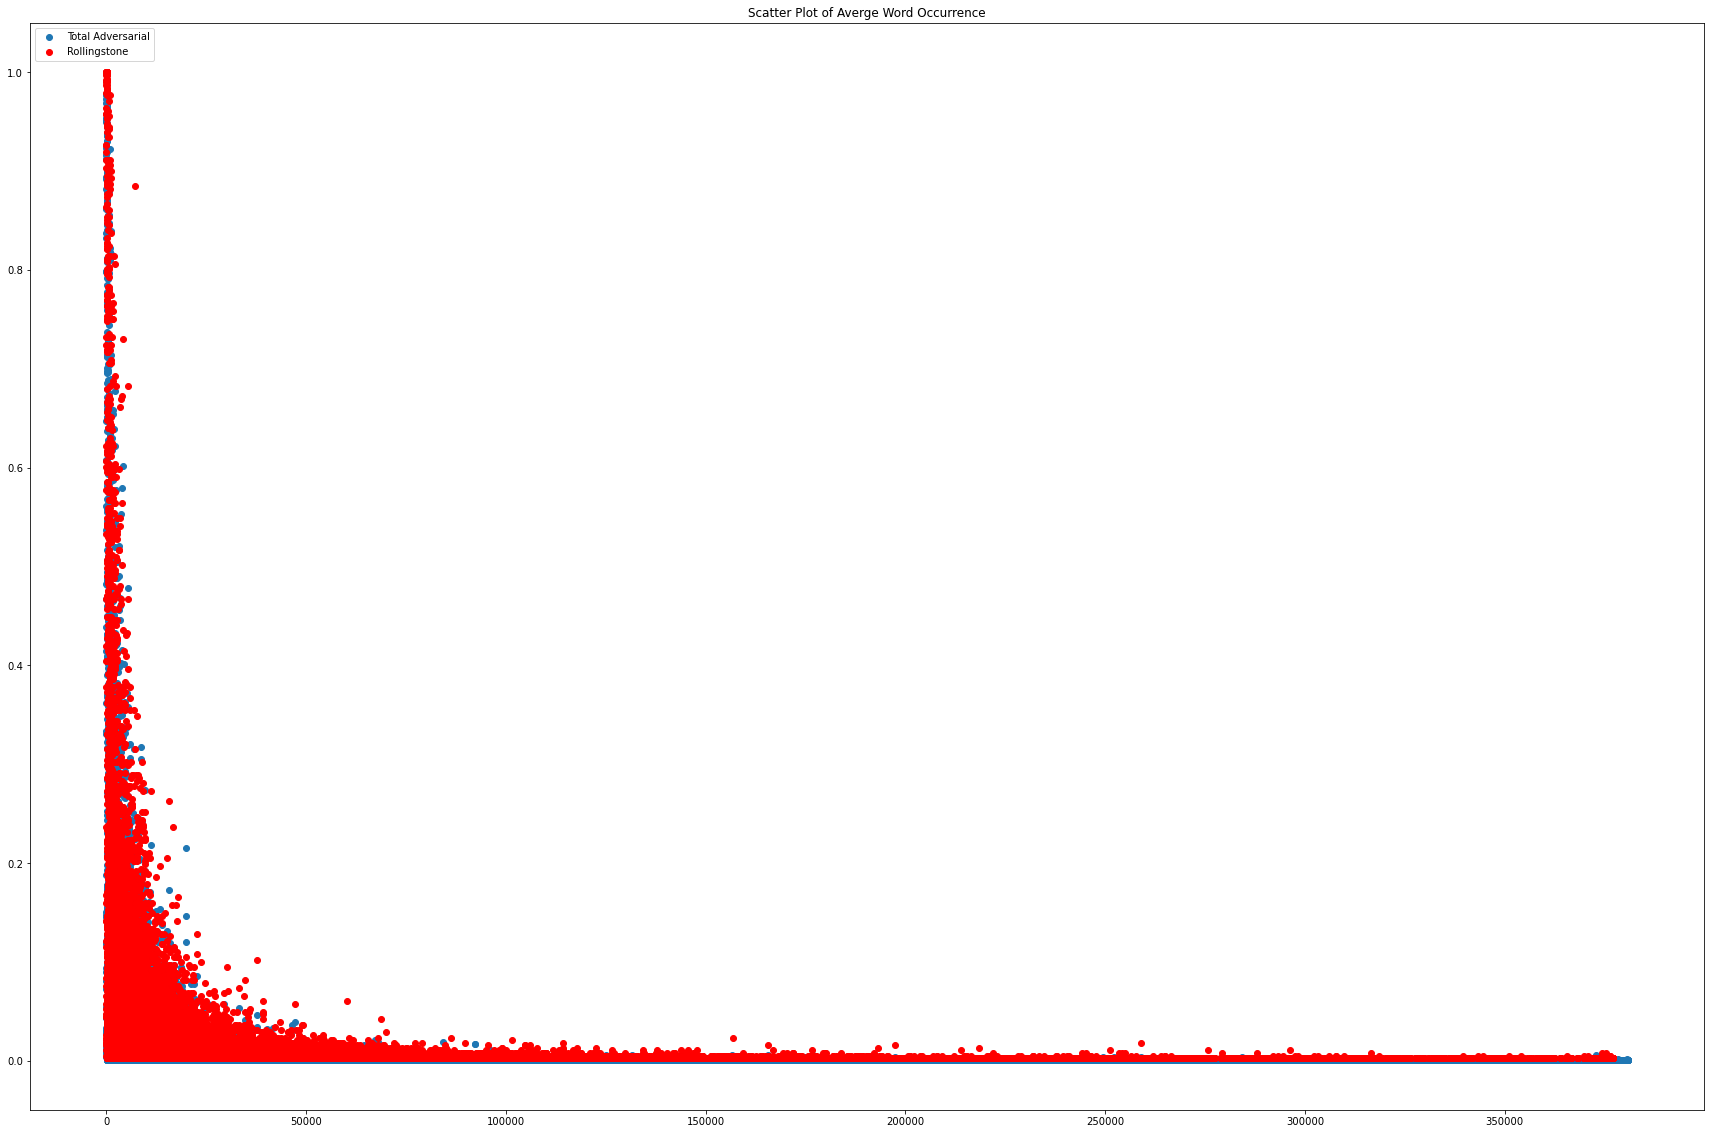

In [28]:
#average unique word occurrence counts for adversarial set as a whole and specifically rollingstone articles
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
total_word_averaged_counts = [x/len(sorted_total_adv) for x in list(zip(*counter.most_common()))[1]]
plt.scatter(list(zip(*counter.most_common()))[0], total_word_averaged_counts, label="Total Adversarial")
rolling_word_averaged_counts = [x/len(rolling_df) for x in list(zip(*rollingcounter.most_common()))[1]]
plt.scatter(list(zip(*rollingcounter.most_common()))[0], rolling_word_averaged_counts, color="red", label="Rollingstone")
plt.legend(loc='upper left');
plt.title("Scatter Plot of Averge Word Occurrence")
plt.show();

In [60]:
word_averages_difference = []
for i in range(len(rolling_word_averaged_counts)):
    word_averages_difference.append(rolling_word_averaged_counts[i] - total_word_averaged_counts[i])
sorted(word_averages_difference)[-10:]
word_averages_difference.index(0.12553149606299208)

[0.11516010498687668,
 0.11653543307086611,
 0.11803018372703411,
 0.11815616797900264,
 0.1189055118110236,
 0.1197808398950132,
 0.12003018372703411,
 0.12065616797900258,
 0.12315616797900264,
 0.12553149606299208]

141

In [55]:
next((word for word, numero in final_word_ids.items() if numero == 141), "unk")

'perfectly'

0.7480314960629921

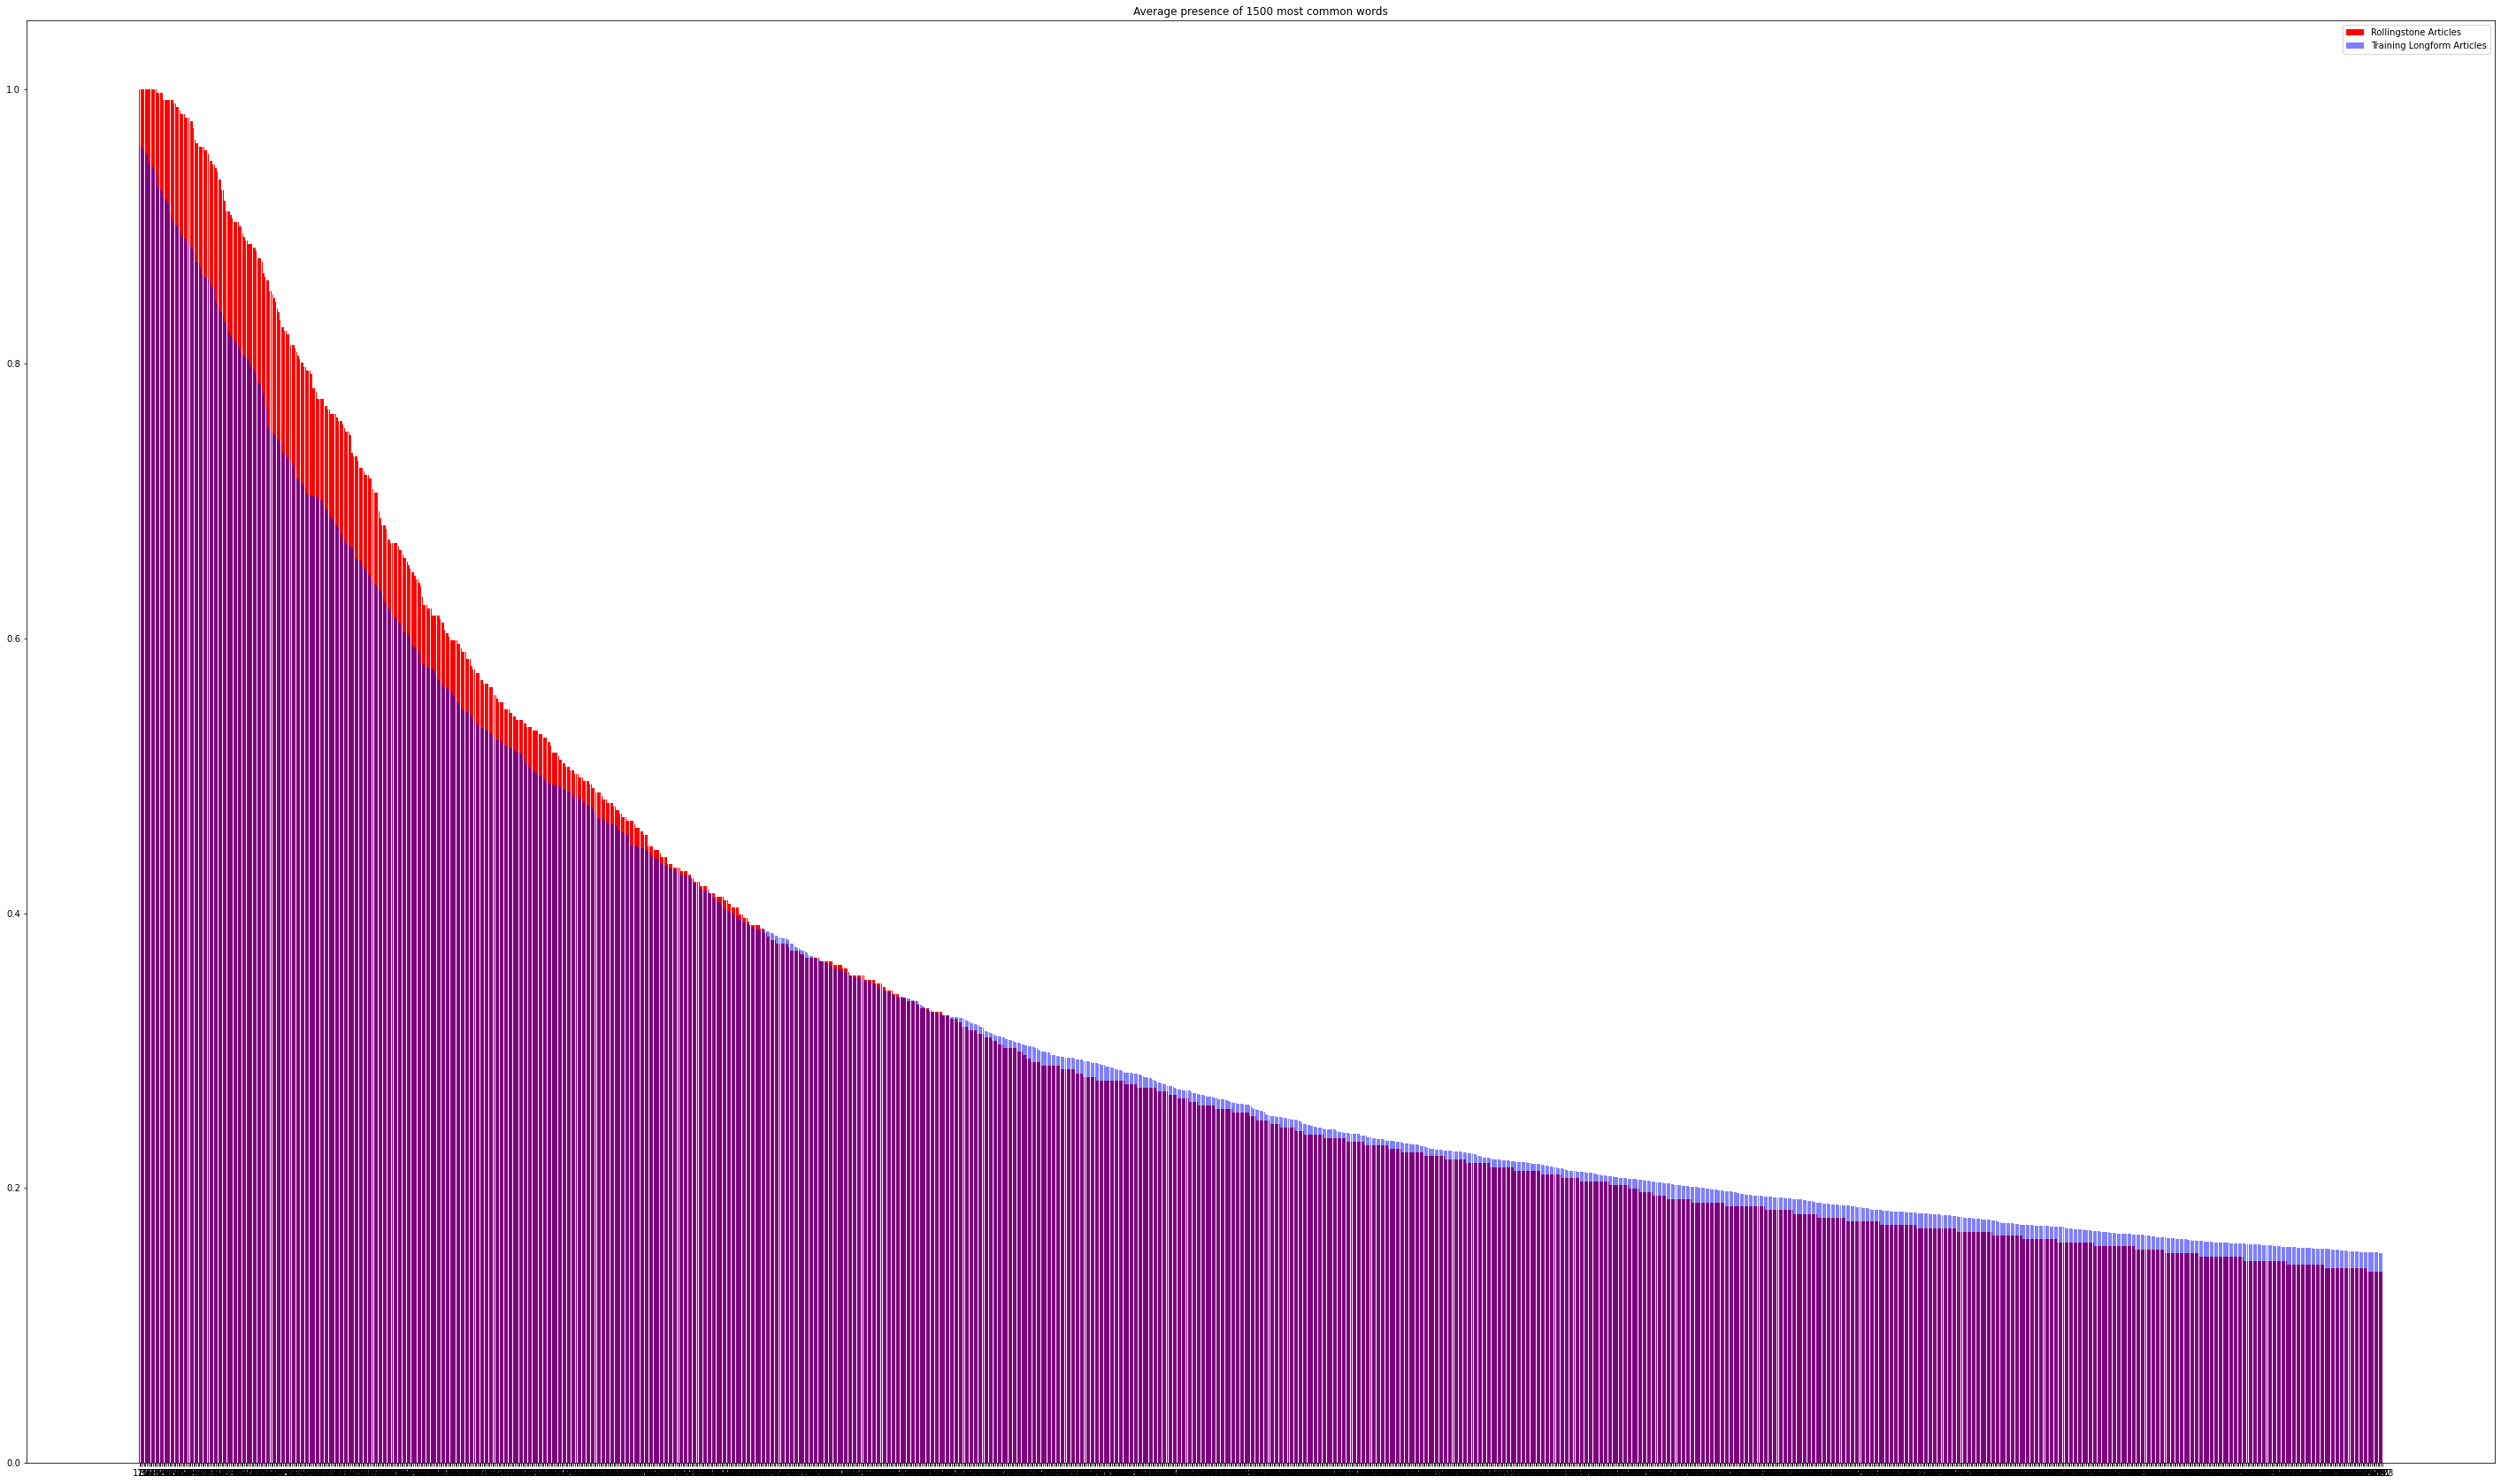

In [43]:
plt.figure(figsize=(50,30))
word_places = list(zip(*rollingcounter.most_common()))[0][:1500]
freqs = list(zip(*rollingcounter.most_common()))[1][:1500]
freqs = [x/(len(rolling_df)) for x in freqs]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="red", label="Rollingstone Articles");
plt.xticks(x_pos, word_places);
word_places = list(zip(*longform_train_counter.most_common()))[0][:1500]
freqs = list(zip(*longform_train_counter.most_common()))[1][:1500]
freqs = [x/(longform_train_article_count) for x in freqs]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="blue", label="Training Longform Articles", alpha=0.5);
plt.xticks(x_pos, word_places);
plt.legend(loc='upper right');
plt.title("Average presence of 1500 most common words")
plt.show();

In [61]:
#Getting inner product values from embedding multiplication with each word attribute
publication_emb = model.publication_embeddings.weight.data[0].cpu().numpy()
word_emb = model.attribute_emb_sum.weight.data.cpu().numpy()
word_emb.shape
inner_products = (publication_emb * word_emb).sum(axis=1)
inner_products[141]

(380917, 100)

-2.8630838

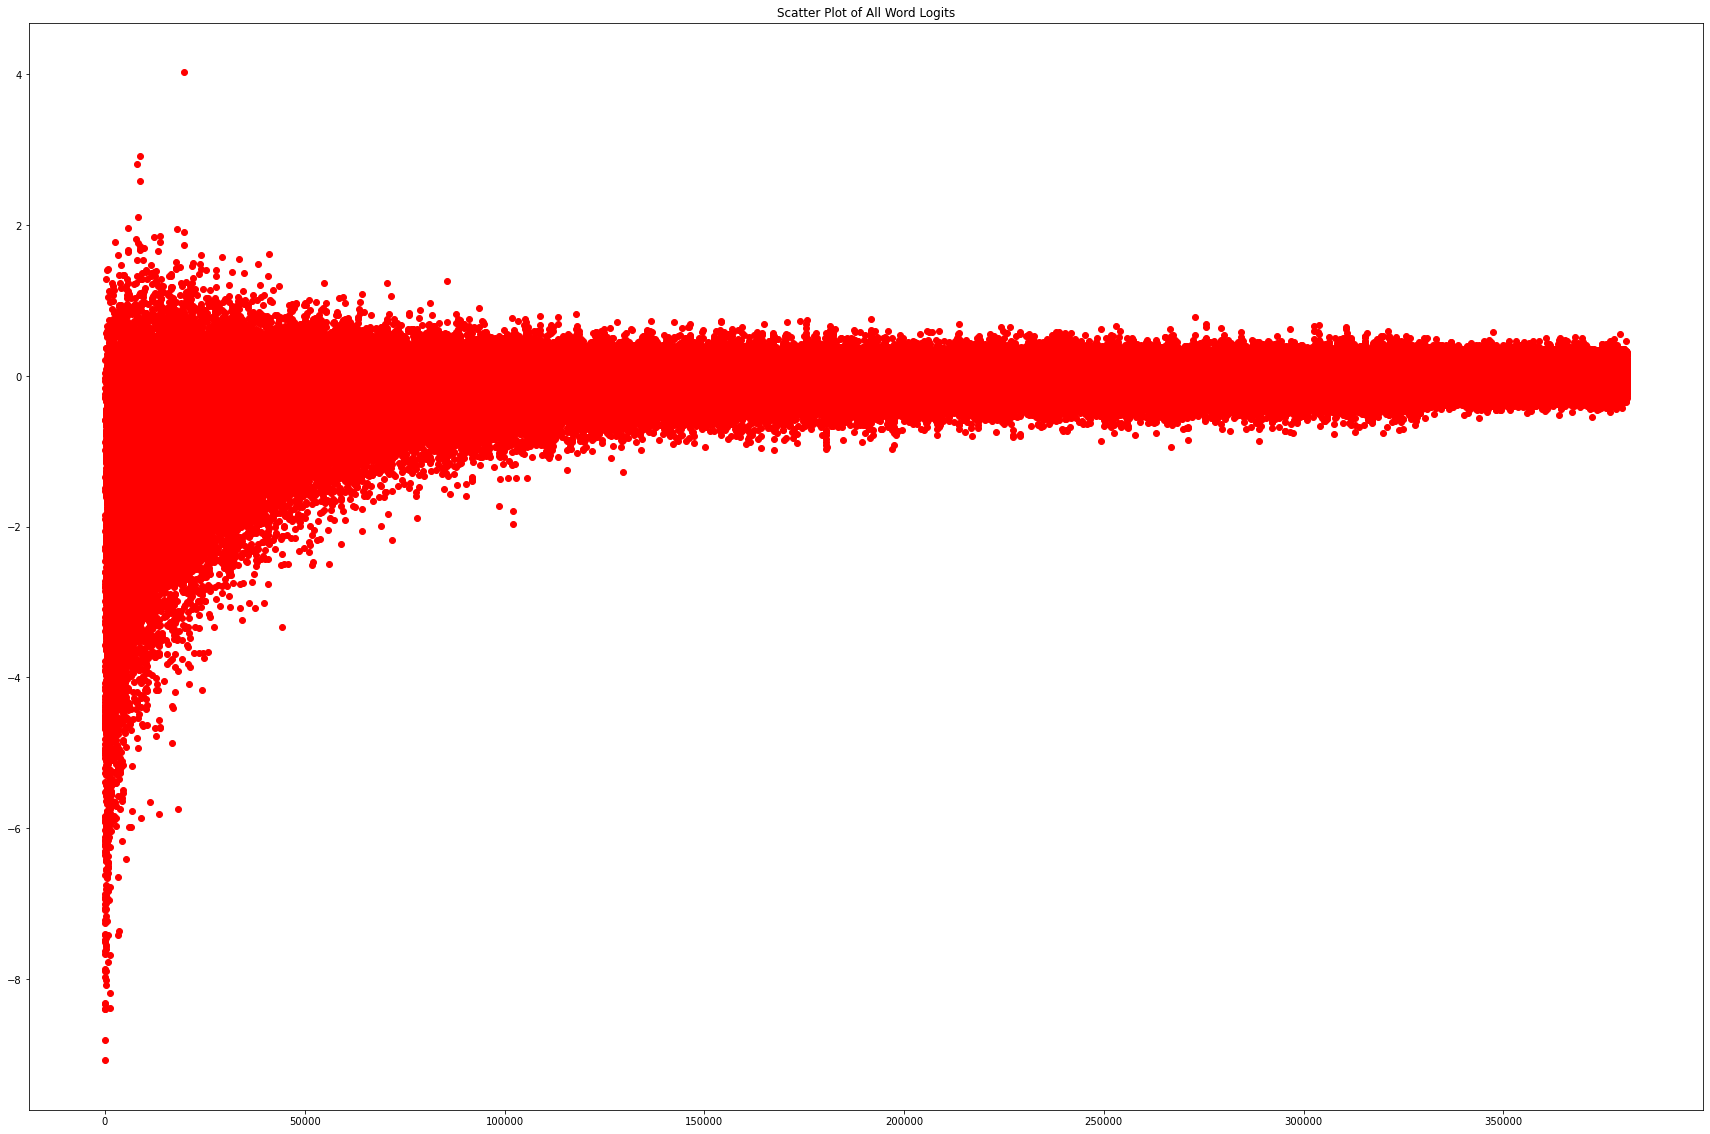

In [31]:
#scatter plot of all word logit values
plt.figure(figsize=(30,20))
plt.scatter(*zip(*enumerate(inner_products)), color="red")
plt.title("Scatter Plot of All Word Logits")
plt.show();

In [32]:
sorted_product_idx = np.argsort(inner_products)
most_weighted = []
least_weighted = []
for x in sorted_product_idx[-500:]:
    most_weighted.append((x, inner_products[x]))
for x in sorted_product_idx[:500]:
    least_weighted.append((x, inner_products[x]))
extreme_weighted = most_weighted + least_weighted

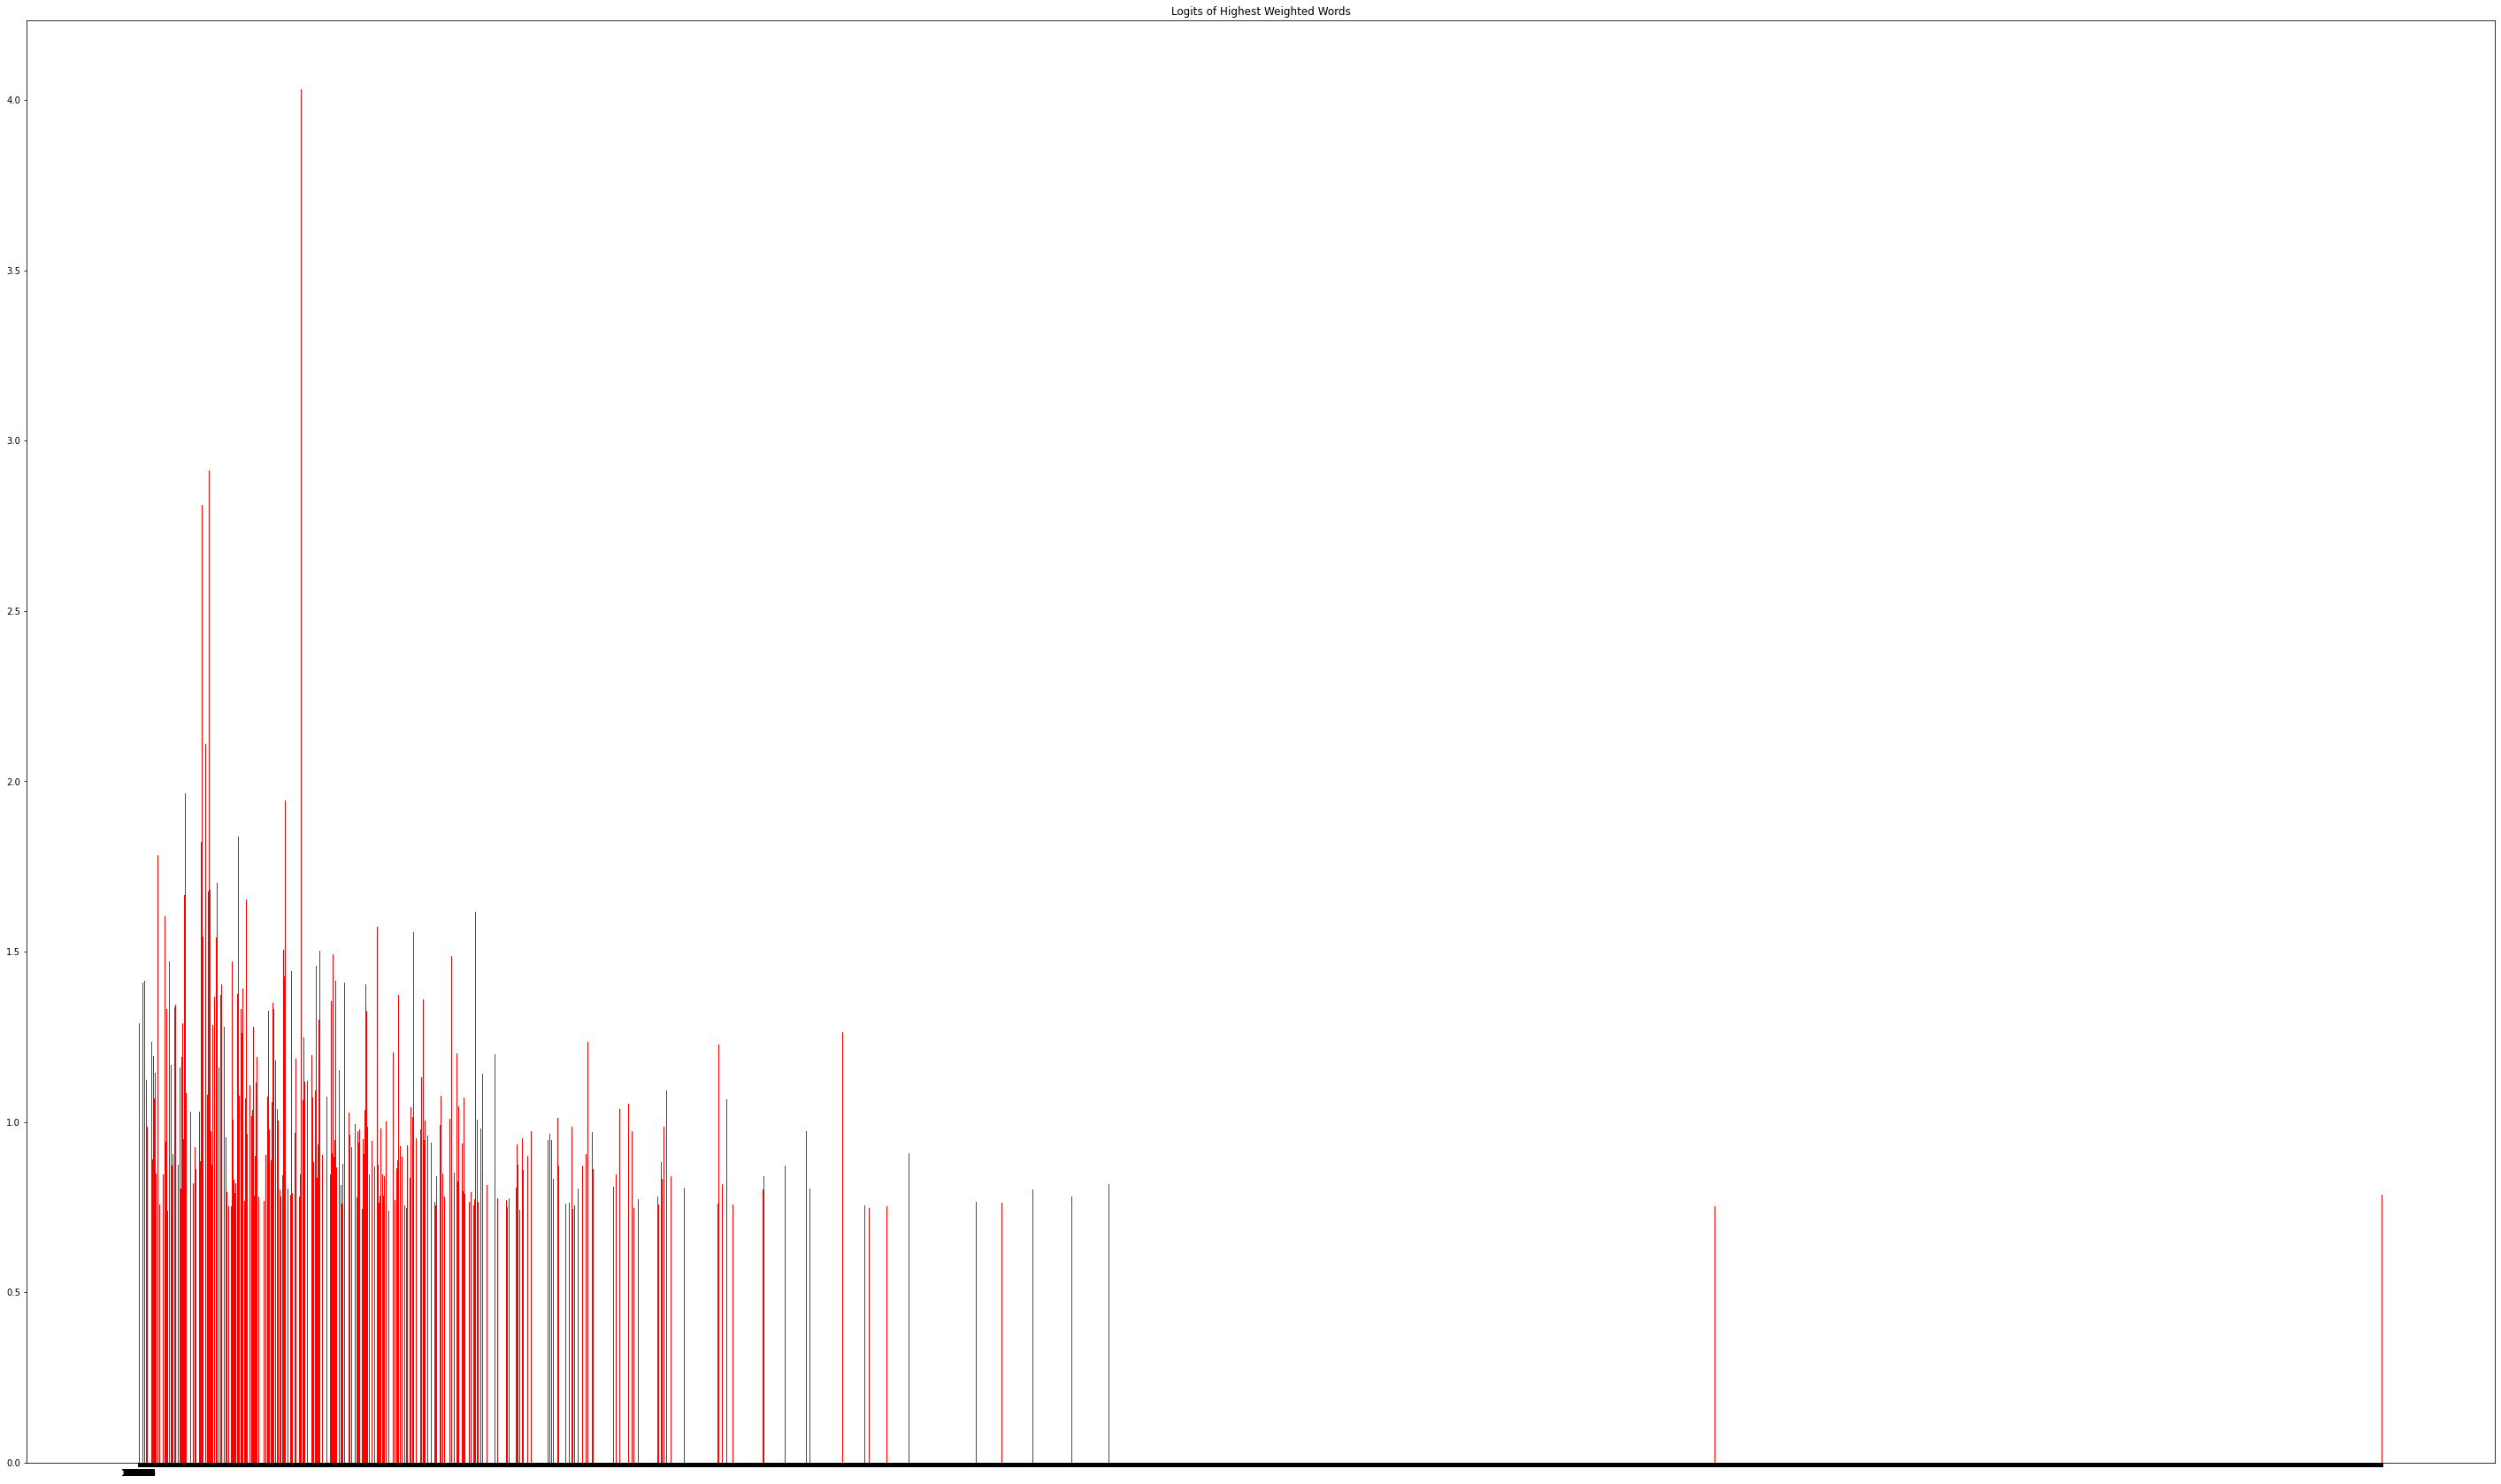

In [33]:
word_idx = list(zip(*most_weighted))[0]
weights = list(zip(*most_weighted))[1]
x_pos = np.arange(max(word_idx))
plt.figure(figsize=(50,30))
plt.bar(word_idx, weights, color="red", width=100, align="center")
plt.title("Logits of Highest Weighted Words")
plt.xticks(x_pos, word_idx)
plt.show();

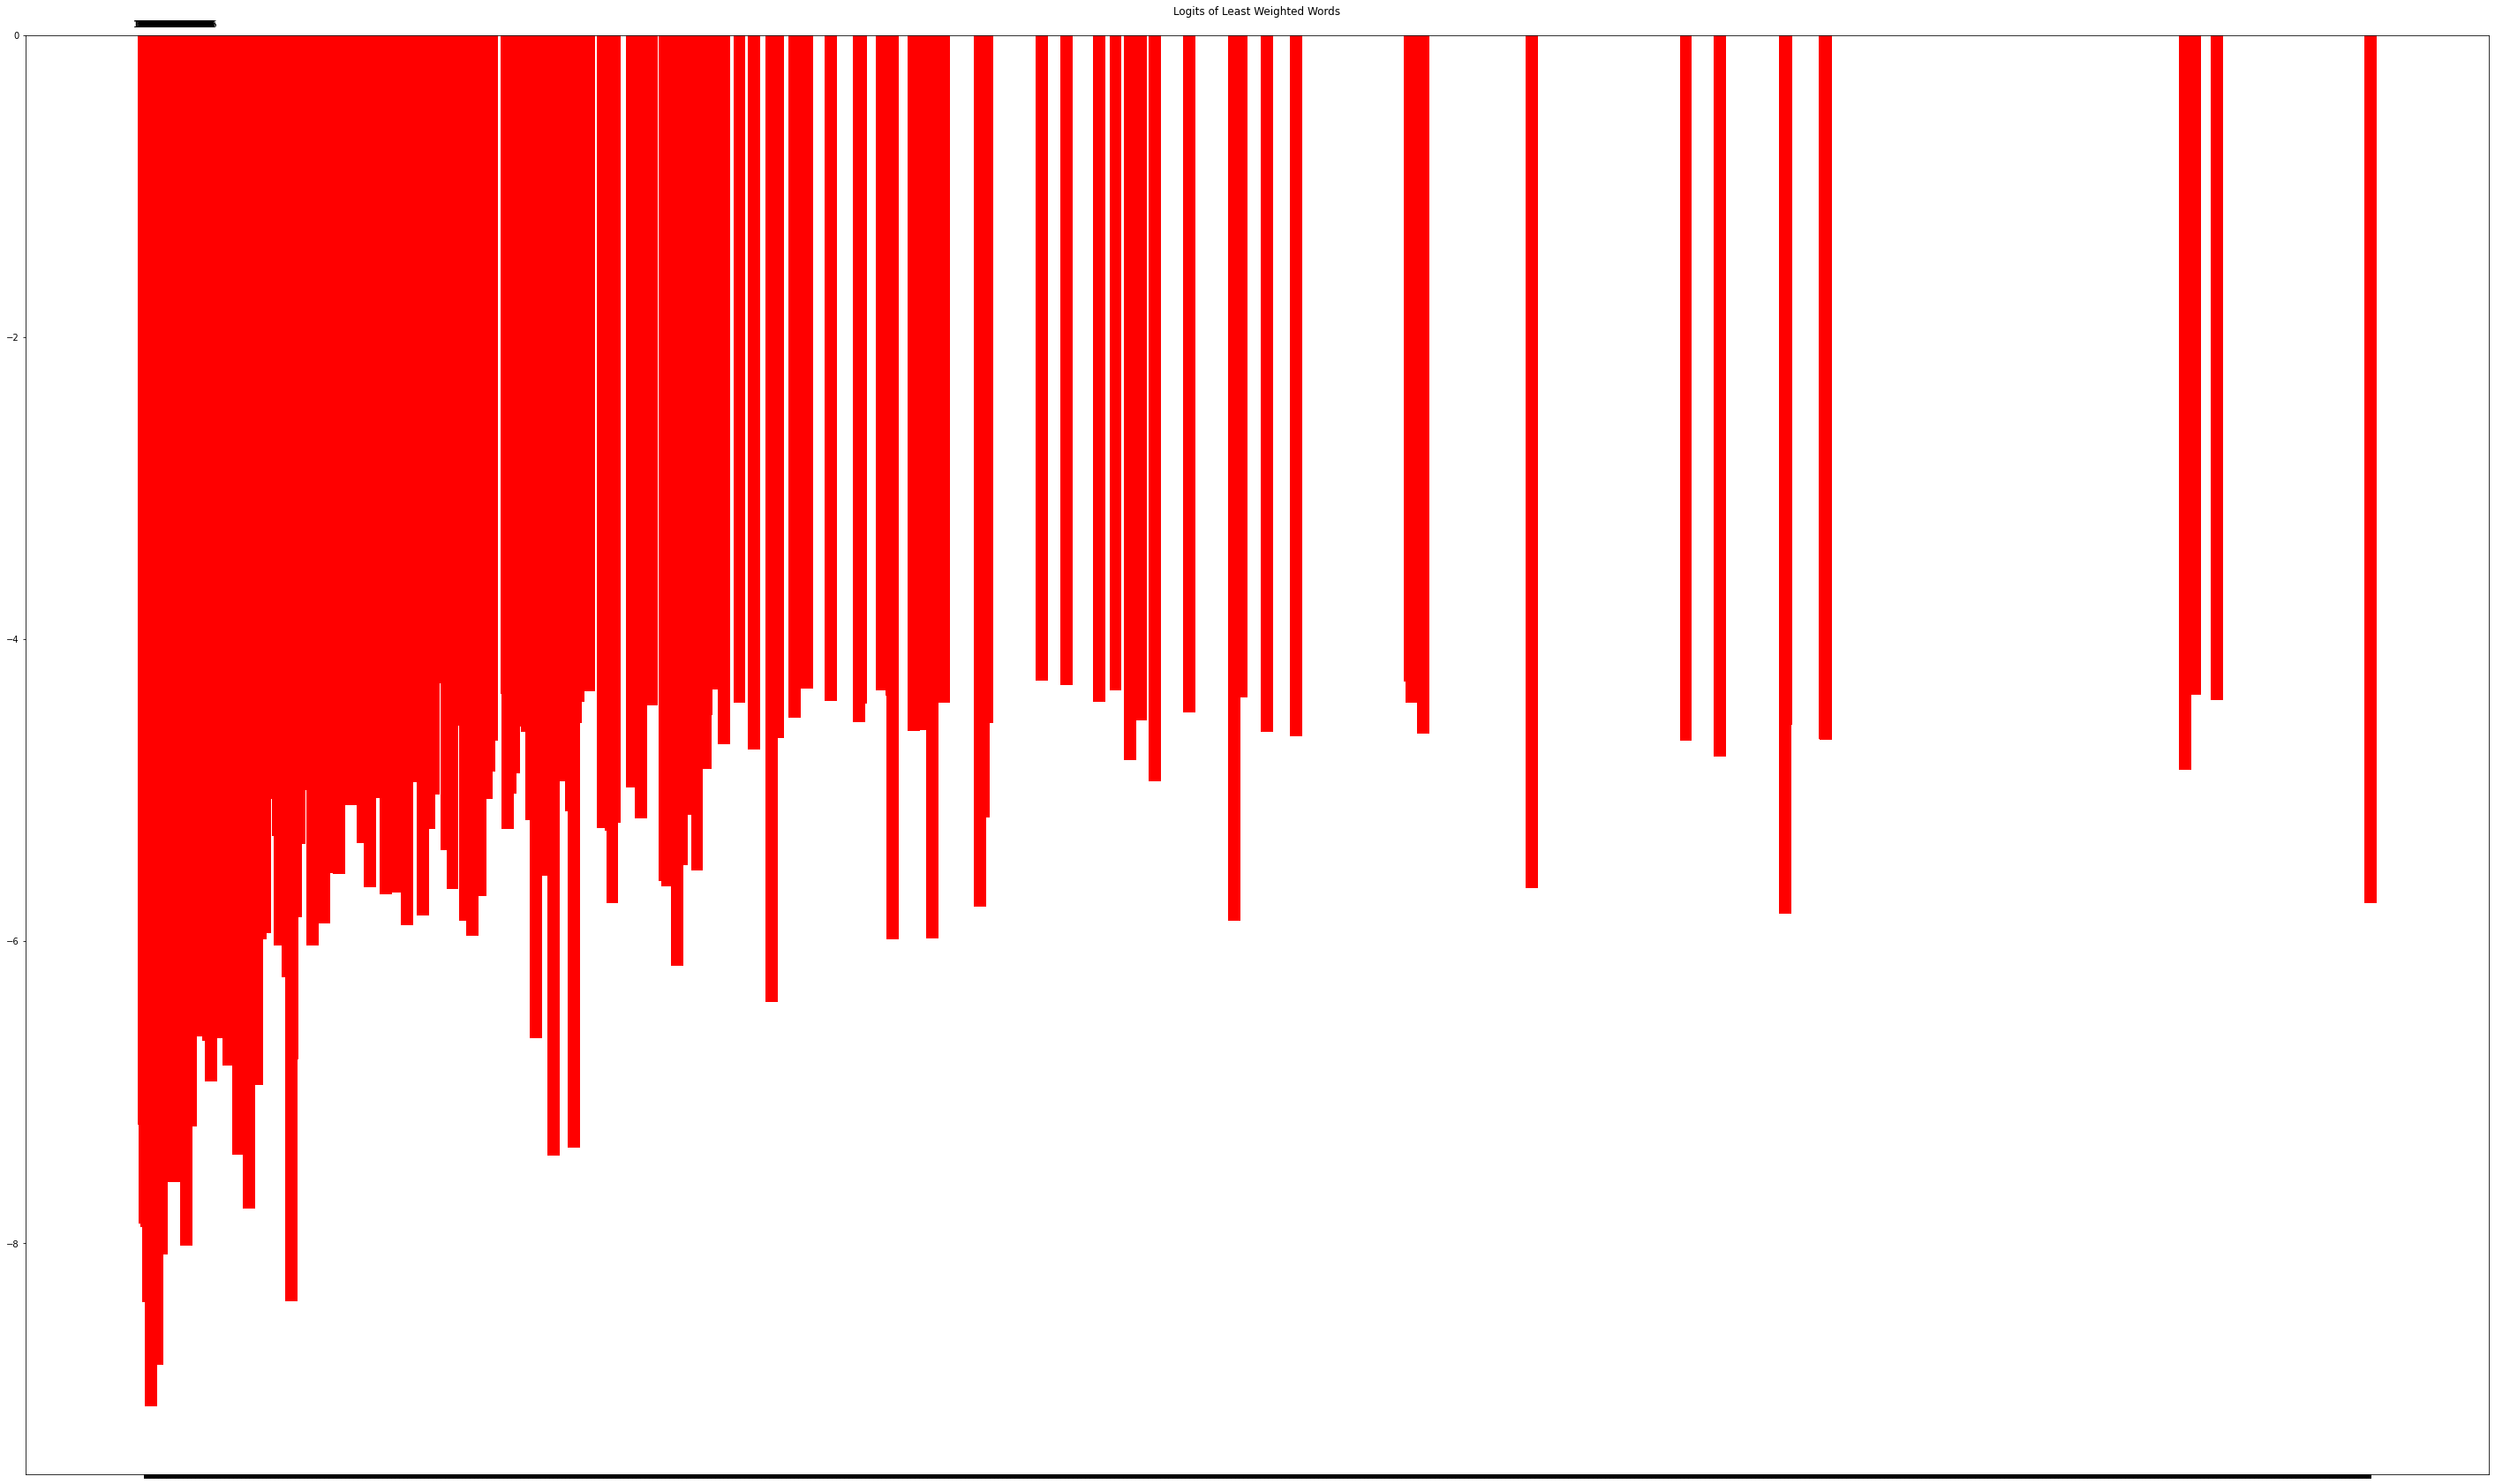

In [34]:
word_idx = list(zip(*least_weighted))[0]
weights = list(zip(*least_weighted))[1]
x_pos = np.arange(max(word_idx))
plt.figure(figsize=(50,30))
plt.bar(word_idx, weights, color="red", width=100, align="center")
plt.title("Logits of Least Weighted Words")
plt.tick_params(labelbottom=False,labeltop=True)
plt.xticks(x_pos, word_idx)
plt.show();

In [35]:
print("Heaviest Weighted")
print("------------------------")
for x in sorted_product_idx[-50:]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Heaviest Weighted
------------------------
Word:  remarked   --------  1.3694483
Word:  bedroom   --------  1.3726575
Word:  shred   --------  1.3732644
Word:  waved   --------  1.3753072
Word:  dude   --------  1.3899627
Word:  café   --------  1.4031549
Word:  pants   --------  1.4037305
Word:  classes   --------  1.4089849
Word:  camouflage   --------  1.4102098
Word:  janitor   --------  1.4130875
Word:  shoulders   --------  1.414983
Word:  pauses   --------  1.4172268
Word:  alligators   --------  1.4269701
Word:  waited   --------  1.443555
Word:  graduating   --------  1.4583246
Word:  smiles   --------  1.4711791
Word:  blinking   --------  1.4713855
Word:  bangs   --------  1.4880313
Word:  acid   --------  1.4911706
Word:  dangling   --------  1.5026333
Word:  bounced   --------  1.5061781
Word:  ten   --------  1.5425278
Word:  heaven   --------  1.5443299
Word:  niggers   --------  1.5563042
Word:  meth   --------  1.5732015
Word:  cell   --------  1.6044642
Word:  engines

In [36]:
sorted_product_idx = np.argsort(inner_products)
print("Least Weighted")
print("------------------------")
for x in sorted_product_idx[:50]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Least Weighted
------------------------
Word:  vox   --------  -9.080217
Word:  the   --------  -8.807129
Word:  of   --------  -8.394557
Word:  in   --------  -8.393323
Word:  uncovering   --------  -8.385888
Word:  s   --------  -8.329216
Word:  a   --------  -8.321117
Word:  digital   --------  -8.189841
Word:  that   --------  -8.0782175
Word:  us   --------  -8.01909
Word:  as   --------  -7.9725933
Word:  is   --------  -7.8977776
Word:  was   --------  -7.892401
Word:  to   --------  -7.874422
Word:  video   --------  -7.7702637
Word:  explaining   --------  -7.6766505
Word:  it   --------  -7.670389
Word:  have   --------  -7.628528
Word:  this   --------  -7.5987105
Word:  than   --------  -7.564042
Word:  at   --------  -7.543051
Word:  are   --------  -7.5048866
Word:  for   --------  -7.4805856
Word:  more   --------  -7.477885
Word:  an   --------  -7.4597216
Word:  pinterest   --------  -7.4226646
Word:  by   --------  -7.4155025
Word:  pic   --------  -7.413398
Word:  wh

In [37]:
rollingcounts  = []
othercounts = []
for example in adv_data.examples:
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    if "rollingstone" in url:
        rollingcounts.append(len(list(set(example['text']))))
    else:
        othercounts.append(len(list(set(example['text']))))

In [38]:
rollingcounts = np.asarray(rollingcounts)
othercounts = np.asarray(othercounts)
print("Average Unique Words in Rollingstone Article: ", int(rollingcounts.mean()))
print("Average Unique Words in remaining adv data Articles: ", int(othercounts.mean()))

Average Unique Words in Rollingstone Article:  750
Average Unique Words in remaining adv data Articles:  324


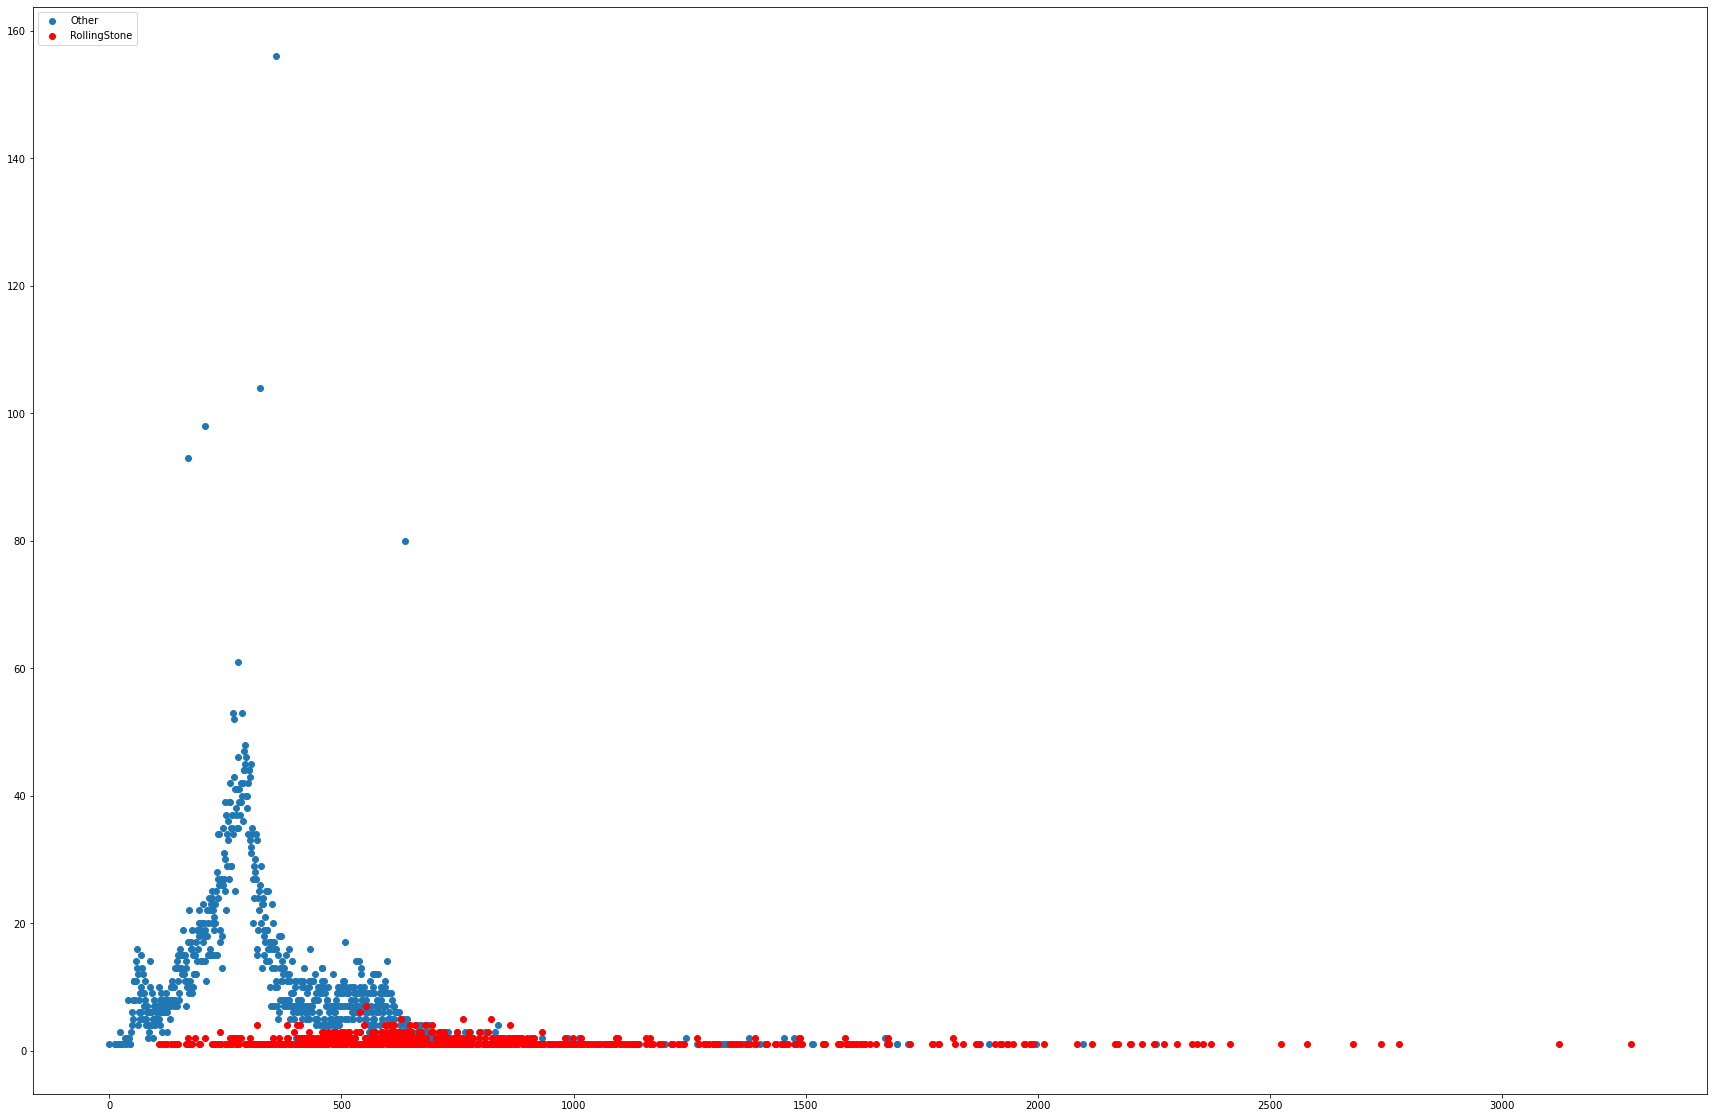

In [39]:
#Unique word counts for rollingstone articles compared to rest of adv_data
rolling_word_count_freq = collections.Counter()
rolling_word_count_freq.update(rollingcounts.tolist())
other_word_count_freq = collections.Counter()
other_word_count_freq.update(othercounts.tolist())

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*other_word_count_freq.most_common()), label="Other")
ax1.scatter(*zip(*rolling_word_count_freq.most_common()), color="red", label="RollingStone")
plt.legend(loc='upper left');
plt.show();

In [40]:
final_word_ids.get("stone")
inner_products[7213]

220

-1.2696978

In [ ]:
for x,y in rollingcounter.most_common()[:100]:
    final=True
    for j,k in counter.most_common()[:100]:
        if x==j:
            final=False
            break
    if final:
        print(x)